<h1>Notebook to model electricity price differences.</h1><br>
Brief summary of the exercise:
* Target: predict the price change of electricity from the Close price of one hour to the Close price of the next hour
* Input: the elementwise difference between the hourly 'candels' of the electricity price; explanation follows.

  Hourly candels refers to the Open, High, Low, Close prices and the total Volume traded within an hour; thus each hourly candel has five elements. Historically, one could reconstruct these candels for each consecutive hour. We refer to the length of history for which the candels are reconstructed as 'window_size'. Thus, for a window_size of 5, one has candels from 5 consecutive hours.
  
  Left to explain is the 'elementwise difference' remark. Out of the N window_size of history, we compute differences between the consecutive candels: Open in t minus Open in t-1, Low in t minus low in t-1, etc. Thus, from N candels we create N-1 differentiated candels.

  In this exercise, the elementwise differentiated data for window_sizes of 5 and 15 are provided

  The data is further enchanced by mostly encoded time-related information. These encode what day of the week the data correspond to, whether the day is a bank holiday or not, etc. A list will be given further below.

* ML models are to be built to predict the Target from the Input data.

<h1>The content of the dataframe is the following:</h1><br>

Content of the dataframes:
* "y" - Target data
   * y: the Close price in t minus Close price in t-1 Target data
* "X" - Predictor data: various time-encoded data and the differentiated candels:
   * total_hours: hours from the first trade we know for a given contract until delivery start of the same contract
   * dlvry_weekend: whether the electricity is to be delivered on a weekend
   * dlvry_bank_holiday: whether the electricity is to be delivered on a bank holiday
   * dlvry_day_sin and dlvry_day_cos: the sinus-cosinus-encoded value of the day of the delivery day (identifies a day of the week in a circular fashion)
   * dlvry_hour_sin	and dlvry_hour_cos: the sinus-cosinus-encoded value of the delivery hour (idenitifies the hour of the delivery in a circular fashion)
   * lasttrade_...: similar to the delivery time encoding, but for the most recent trading hour used as a candel
   * the numbered columns: window_size - 1 number of differentiated candels with an additional time information: the number of minutes left until delivery start. **<u><em>Example for window_size of 5 follows:</em></u>** 
      * Column 0: Open in t-3 minus Open in t-4; 
      * Column 1: High in t-3 minus High in t-4; 
      * Column 2: similar for Low; 
      * Column 3: similar for Close; 
      * Column 4: similar for Volume; 
      * Column 5: minutes left until the delivery start in candel for t-3; 
      * Column 6: Open in t-2 minus Open in t-3; ...; 
      * Column 23: minutes left until the delivery start in candel for t

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set Pandas Dataframe Display Scopes
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 200)  # or 1000
pd.set_option('display.max_colwidth', 0)

In [2]:
# Load the data using the pandas library
# For the below demonstration, only the
#    * window_size of 5 files
#    * and only the training sets will be loaded here
# The validation and test sets can be similarly loaded.
# One can also use a similar kind of method for loading as was used for the download
# This can avoid the many lines of manual specification of the files. Manual is also fine, btw.

X_train_5 = pd.read_csv('X_train_window_size_5_time_encoding_True.csv')
y_train_5 = pd.read_csv('y_train_window_size_5_time_encoding_True.csv')

# Display the first 5 rows of the predictor and the target data; for a description of the content, see the text below this cell
print("Predictor data:")
display(X_train_5.head())
print("Target data:")
display(y_train_5.head())

Predictor data:


,total_hours,dlvry_weekend,dlvry_bank_holiday,dlvry_day_sin,dlvry_day_cos,dlvry_weekday_sin,dlvry_weekday_cos,dlvry_hour_sin,dlvry_hour_cos,lasttrade_weekend,lasttrade_bank_holiday,lasttrade_day_sin,lasttrade_day_cos,lasttrade_weekday_sin,lasttrade_weekday_cos,lasttrade_hour_sin,lasttrade_hour_cos,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.707107,-7.071068e-01,0.03,0.80,-1.17,-1.18,92.2,600.0,-9.51,-1.98,-8.31,-2.83,176.6,540.0,5.48,2.58,5.39,5.41,187.7,480.0,4.41,-0.21,1.30,-1.31,-18.2,420.0
1,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.866025,-5.000000e-01,-9.51,-1.98,-8.31,-2.83,176.6,540.0,5.48,2.58,5.39,5.41,187.7,480.0,4.41,-0.21,1.30,-1.31,-18.2,420.0,-0.31,-0.20,-0.66,-3.18,-78.3,360.0
2,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.965926,-2.588190e-01,5.48,2.58,5.39,5.41,187.7,480.0,4.41,-0.21,1.30,-1.31,-18.2,420.0,-0.31,-0.20,-0.66,-3.18,-78.3,360.0,-3.49,-2.59,-7.97,-3.21,796.3,300.0
3,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-1.000000,-1.836970e-16,4.41,-0.21,1.30,-1.31,-18.2,420.0,-0.31,-0.20,-0.66,-3.18,-78.3,360.0,-3.49,-2.59,-7.97,-3.21,796.3,300.0,-2.90,-1.69,2.44,-0.01,-355.6,240.0
4,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.965926,2.588190e-01,-0.31,-0.20,-0.66,-3.18,-78.3,360.0,-3.49,-2.59,-7.97,-3.21,796.3,300.0,-2.90,-1.69,2.44,-0.01,-355.6,240.0,-0.70,-1.11,-1.11,-2.69,53.3,180.0


Target data:


,y
0,-3.18
1,-3.21
2,-0.01
3,-2.69
4,2.41


**Notebook to model electricity price differences.**<br>

In [5]:
############################## Check if there is any NaN value
null_num = X_train_5.isnull().values.sum()
print(f'There is {null_num} null value in X_train_5')

There is 0 null value in X_train_5


In [6]:
############################## Check out first 17 columns
X_train_5.iloc[0:31, 0:18]

,total_hours,dlvry_weekend,dlvry_bank_holiday,dlvry_day_sin,dlvry_day_cos,dlvry_weekday_sin,dlvry_weekday_cos,dlvry_hour_sin,dlvry_hour_cos,lasttrade_weekend,lasttrade_bank_holiday,lasttrade_day_sin,lasttrade_day_cos,lasttrade_weekday_sin,lasttrade_weekday_cos,lasttrade_hour_sin,lasttrade_hour_cos,0
0,10.001383,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.500000,8.660254e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.707107,-7.071068e-01,0.03
1,10.001383,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.500000,8.660254e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.866025,-5.000000e-01,-9.51
2,10.001383,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.500000,8.660254e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.965926,-2.588190e-01,5.48
3,10.001383,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.500000,8.660254e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-1.000000,-1.836970e-16,4.41
4,10.001383,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.500000,8.660254e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.965926,2.588190e-01,-0.31
5,7.080482,0.0,0.0,0.394356,0.918958,0.000000,1.00000,0.258819,9.659258e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.707107,7.071068e-01,0.00
6,7.080482,0.0,0.0,0.394356,0.918958,0.000000,1.00000,0.258819,9.659258e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.500000,8.660254e-01,1.77
7,7.726036,0.0,0.0,0.394356,0.918958,0.000000,1.00000,0.500000,8.660254e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.500000,8.660254e-01,-0.21
8,7.726036,0.0,0.0,0.394356,0.918958,0.000000,1.00000,0.500000,8.660254e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.258819,9.659258e-01,-1.69
9,8.726036,0.0,0.0,0.394356,0.918958,0.000000,1.00000,0.707107,7.071068e-01,1.0,0.0,0.201299,0.979530,-0.781831,0.62349,-0.500000,8.660254e-01,-0.60


In [14]:
############################## Check out stats of first 17 columns
X_train_5.iloc[:, :17].describe()

,total_hours,dlvry_weekend,dlvry_bank_holiday,dlvry_day_sin,dlvry_day_cos,dlvry_weekday_sin,dlvry_weekday_cos,dlvry_hour_sin,dlvry_hour_cos,lasttrade_weekend,lasttrade_bank_holiday,lasttrade_day_sin,lasttrade_day_cos,lasttrade_weekday_sin,lasttrade_weekday_cos,lasttrade_hour_sin,lasttrade_hour_cos
count,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000
mean,21.076573,0.278215,0.031876,0.049590,-0.031720,0.012716,-0.006560,-0.274853,-0.172969,0.278958,0.031111,0.051690,-0.028087,0.012946,-0.002537,0.167920,0.272985
std,5.485763,0.448122,0.175670,0.702321,0.709430,0.706995,0.707081,0.704416,0.631146,0.448489,0.173618,0.701305,0.710437,0.707360,0.706739,0.640014,0.698336
min,6.008203,0.000000,0.000000,-0.998717,-1.000000,-0.974928,-0.900969,-1.000000,-1.000000,0.000000,0.000000,-0.998717,-1.000000,-0.974928,-0.900969,-1.000000,-1.000000
25%,16.997189,0.000000,0.000000,-0.651372,-0.758758,-0.781831,-0.900969,-0.866025,-0.707107,0.000000,0.000000,-0.651372,-0.758758,-0.781831,-0.900969,-0.500000,-0.258819
50%,21.958922,0.000000,0.000000,0.101168,-0.050649,0.000000,-0.222521,-0.500000,-0.258819,0.000000,0.000000,0.101168,-0.050649,0.000000,-0.222521,0.258819,0.500000
75%,25.484821,1.000000,0.000000,0.743145,0.688967,0.781831,0.623490,0.500000,0.500000,1.000000,0.000000,0.743145,0.688967,0.781831,0.623490,0.707107,0.866025
max,31.999669,1.000000,1.000000,1.000000,1.000000,0.974928,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.974928,1.000000,1.000000,1.000000


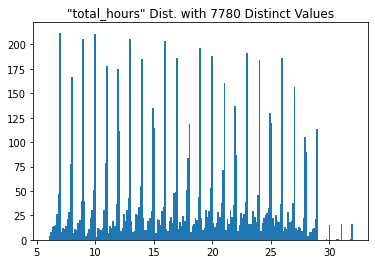

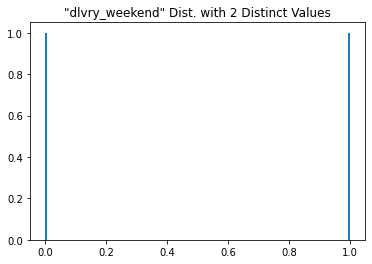

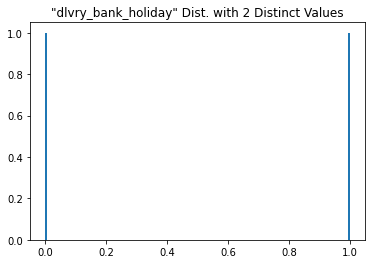

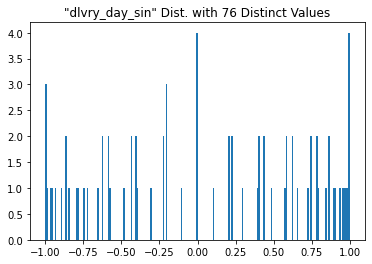

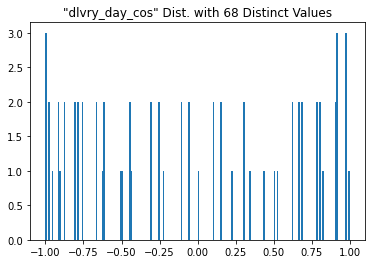

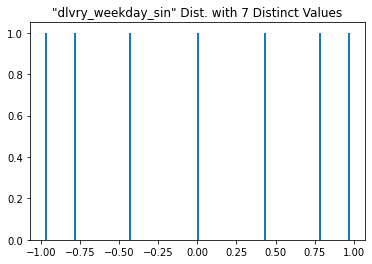

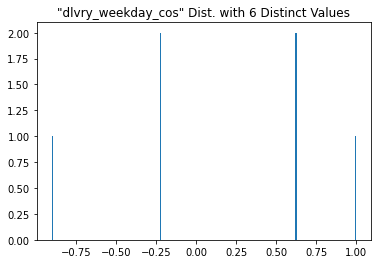

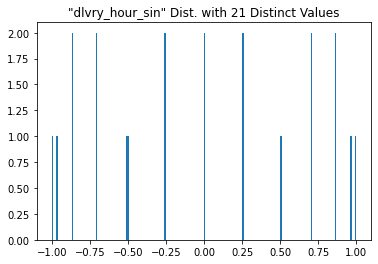

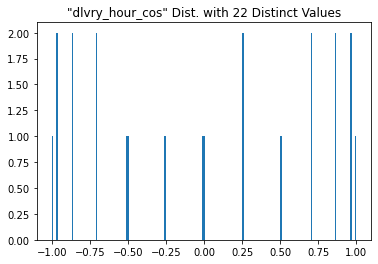

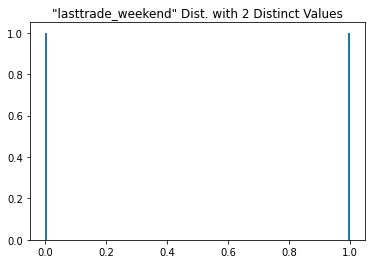

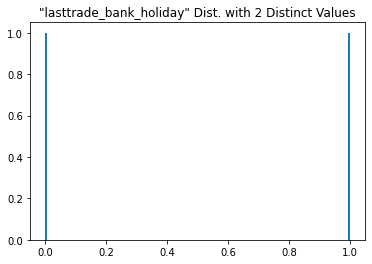

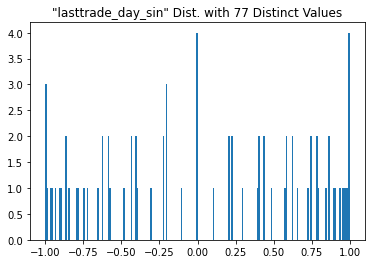

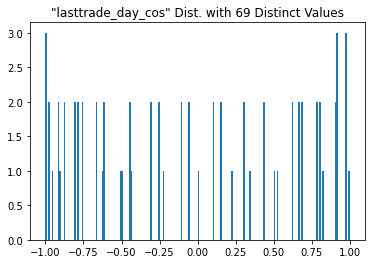

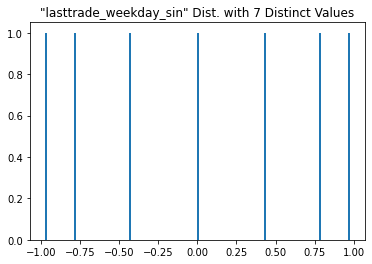

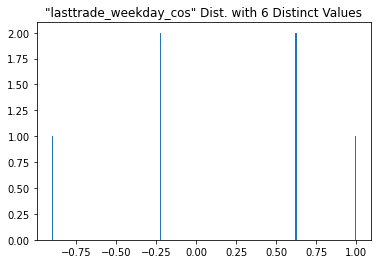

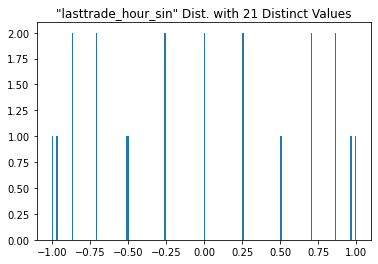

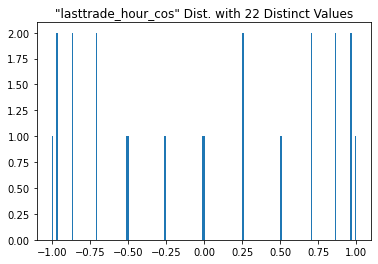

In [11]:
############################## Func: display unique values for first 17 columns ##############################
######## Since most columns reflect the dataset's cyclical nature, many columns must have many repatitive values
def feature_values(df, end_col):
    for col in df.iloc[:,:end_col]:
        unique_values = np.unique(df[col])
        plt.hist(unique_values, bins=200)
        # _ = plt.hist(unique_values, bins='auto')
        plt.title(f'"{col}" Dist. with {unique_values.shape[0]} Distinct Values')
        plt.show()

feature_values(X_train_5, 17)


In [12]:
############################## Check out timestamp columns: "0" ~ "23"
pd.concat([X_train_5.loc[0:30,'total_hours'], X_train_5.iloc[0:31, 17:]], axis=1)

,total_hours,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,10.001383,0.03,0.80,-1.17,-1.18,92.2,600.0,-9.51,-1.98,-8.31,-2.83,176.6,540.0,5.48,2.58,5.39,5.41,187.7,480.0,4.41,-0.21,1.30,-1.31,-18.2,420.0
1,10.001383,-9.51,-1.98,-8.31,-2.83,176.6,540.0,5.48,2.58,5.39,5.41,187.7,480.0,4.41,-0.21,1.30,-1.31,-18.2,420.0,-0.31,-0.20,-0.66,-3.18,-78.3,360.0
2,10.001383,5.48,2.58,5.39,5.41,187.7,480.0,4.41,-0.21,1.30,-1.31,-18.2,420.0,-0.31,-0.20,-0.66,-3.18,-78.3,360.0,-3.49,-2.59,-7.97,-3.21,796.3,300.0
3,10.001383,4.41,-0.21,1.30,-1.31,-18.2,420.0,-0.31,-0.20,-0.66,-3.18,-78.3,360.0,-3.49,-2.59,-7.97,-3.21,796.3,300.0,-2.90,-1.69,2.44,-0.01,-355.6,240.0
4,10.001383,-0.31,-0.20,-0.66,-3.18,-78.3,360.0,-3.49,-2.59,-7.97,-3.21,796.3,300.0,-2.90,-1.69,2.44,-0.01,-355.6,240.0,-0.70,-1.11,-1.11,-2.69,53.3,180.0
5,7.080482,0.00,2.99,0.00,0.00,20.0,420.0,1.77,-1.20,0.00,0.50,40.6,360.0,-1.59,-1.09,-2.65,-2.21,555.0,300.0,-1.90,1.10,0.38,1.61,-332.7,240.0
6,7.080482,1.77,-1.20,0.00,0.50,40.6,360.0,-1.59,-1.09,-2.65,-2.21,555.0,300.0,-1.90,1.10,0.38,1.61,-332.7,240.0,1.94,-1.58,-2.42,-2.26,421.6,180.0
7,7.726036,-0.21,-1.00,1.26,1.26,23.1,420.0,-1.69,0.07,-0.86,-0.36,328.4,360.0,-1.39,0.63,-0.70,2.23,-86.4,300.0,3.02,-0.40,-1.93,-2.61,377.2,240.0
8,7.726036,-1.69,0.07,-0.86,-0.36,328.4,360.0,-1.39,0.63,-0.70,2.23,-86.4,300.0,3.02,-0.40,-1.93,-2.61,377.2,240.0,-2.61,-1.70,0.23,0.49,104.2,180.0
9,8.726036,-0.60,-1.21,-3.48,-4.60,13.0,480.0,-4.08,-1.60,-3.20,-3.20,175.2,420.0,-0.01,5.01,1.99,7.16,108.5,360.0,5.08,-2.93,-0.99,-3.26,121.3,300.0


**Notebook to model electricity price differences.**<br>

In [9]:
############################## Check out stats of timestamp columns: "0" ~ "23"
###### Notice: Column "23" always ends with 180 minutes as the last step!!!!!!!!!!!!!!!!!!
X_train_5.iloc[:, 17:].describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000
mean,0.162057,0.110918,0.159535,0.084212,25.933776,789.619066,0.059150,0.181786,-0.045576,0.059811,38.583757,729.619066,0.060479,0.189616,-0.055592,0.044150,54.931951,669.619066,0.041233,0.195364,-0.098434,0.032456,87.409425,609.619066
std,3.390137,3.206271,3.738540,2.939542,239.837714,325.538011,2.767407,3.074236,3.245567,2.816980,312.331294,325.538011,2.728786,3.157805,3.128701,2.857961,334.903828,325.538011,2.735750,3.308957,3.002296,3.001645,384.474903,325.538011
min,-77.710000,-77.710000,-92.500000,-55.490000,-19986.100000,360.000000,-43.230000,-147.650000,-53.600000,-44.330000,-52469.700000,300.000000,-43.230000,-147.650000,-53.600000,-58.000000,-52469.700000,240.000000,-54.000000,-54.420000,-51.060000,-58.000000,-52469.700000,180.000000
25%,-0.700000,-0.690000,-0.650000,-0.730000,-13.400000,540.000000,-0.700000,-0.650000,-0.720000,-0.790000,-13.500000,480.000000,-0.740000,-0.680000,-0.780000,-0.850000,-14.600000,420.000000,-0.800000,-0.710000,-0.830000,-0.900000,-12.900000,360.000000
50%,0.000000,0.000000,0.000000,0.000000,1.400000,720.000000,0.000000,0.000000,0.000000,0.000000,3.500000,660.000000,0.000000,0.000000,0.000000,0.000000,6.000000,600.000000,0.000000,0.000000,0.000000,0.000000,11.100000,540.000000
75%,0.800000,0.730000,0.800000,0.810000,48.200000,1020.000000,0.770000,0.800000,0.710000,0.850000,68.000000,960.000000,0.800000,0.840000,0.710000,0.890000,93.100000,900.000000,0.820000,0.900000,0.720000,0.940000,134.000000,840.000000
max,63.990000,151.600000,96.400000,65.120000,50436.600000,1860.000000,63.990000,151.600000,96.400000,80.080000,50436.600000,1800.000000,89.250000,104.000000,60.140000,84.480000,50436.600000,1740.000000,100.420000,133.050000,60.140000,129.110000,50436.600000,1680.000000


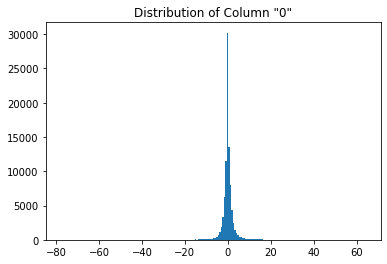

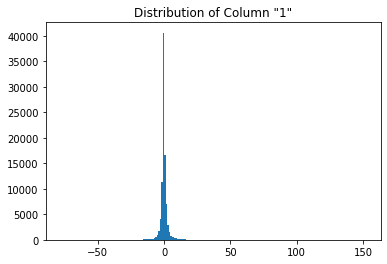

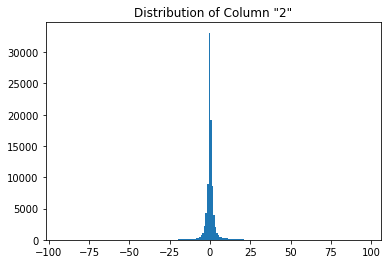

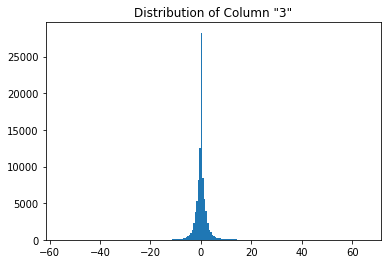

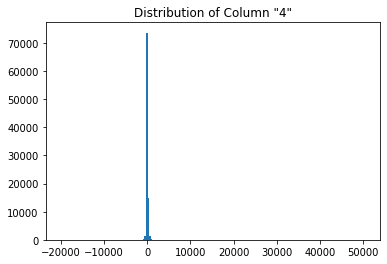

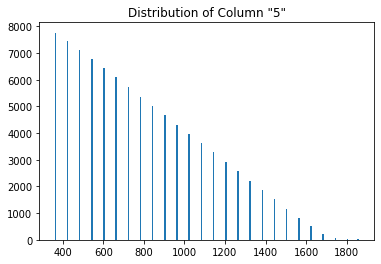

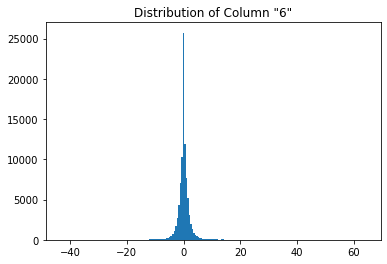

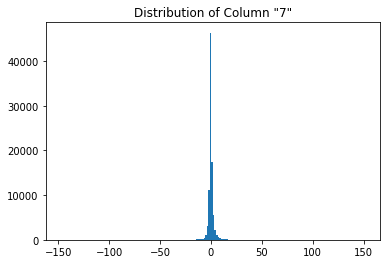

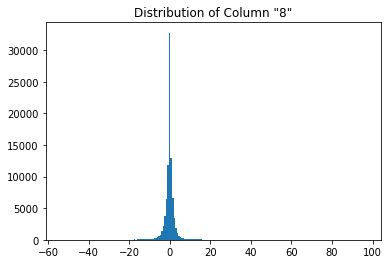

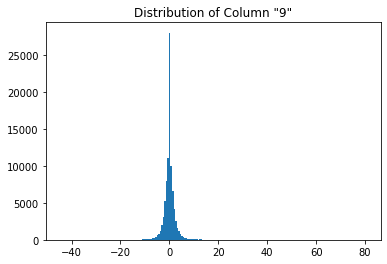

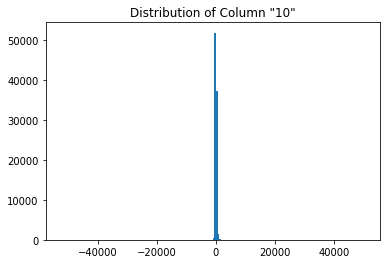

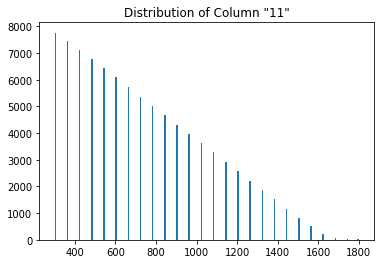

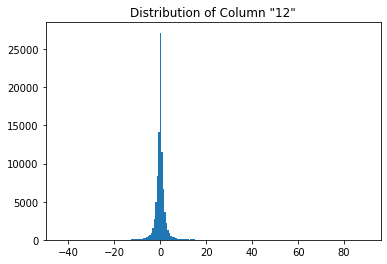

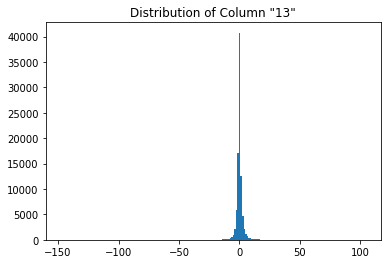

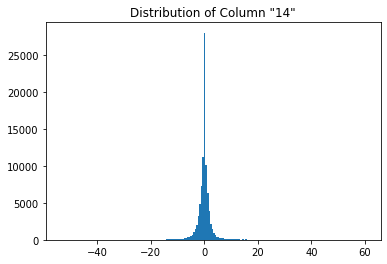

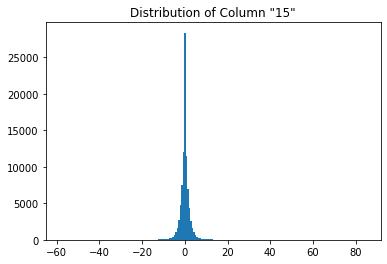

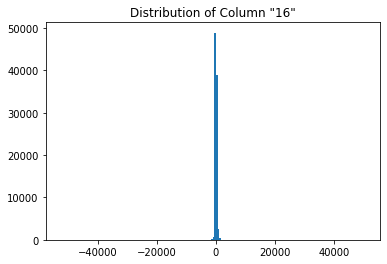

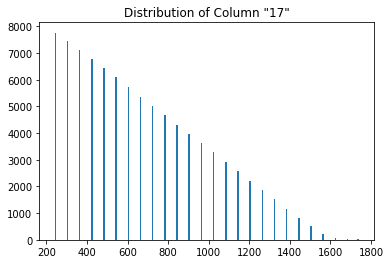

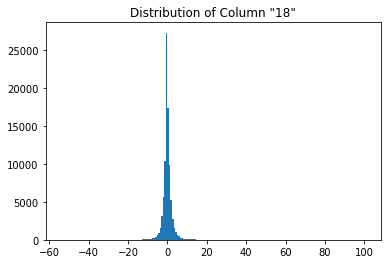

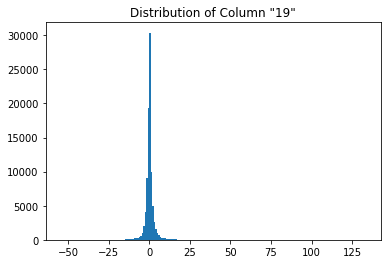

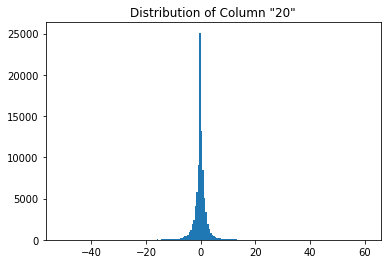

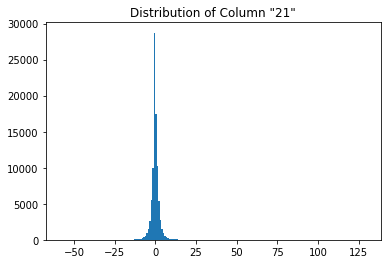

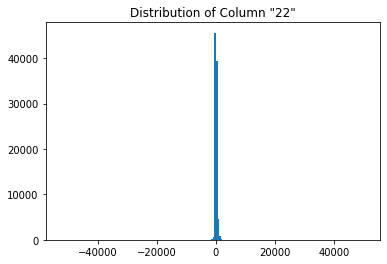

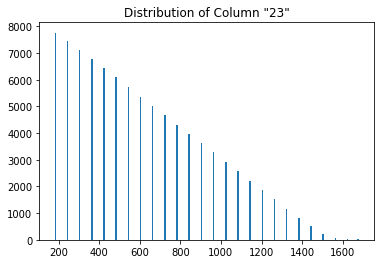

In [10]:
############################## Func: display value Dist. for timestamp columns: "0" ~ "23" ##############################
####### Due to extreme values, many timestamp columns have super 'thin' distributions
def feature_values(df, start_col):
    for col in df.iloc[:, start_col:]:
        values = df[col].values
        plt.hist(values, bins=200)
        plt.title(f'Distribution of Column "{col}"')
        plt.show()

feature_values(X_train_5, 17)